# Predictive-Coding Diffusion (PC-Diffusion) with Heun Sampler

This notebook trains a small diffusion model on CIFAR-10 and samples with a 2nd-order **Heun** ODE solver.
We adopt the EDM training recipe (noise distribution, loss weighting) and step schedule, and re-interpret the denoiser as a **predictive-coding module** that estimates the clean image \(x_0\) from \(x_\sigma\); the per-step **error** acts as the predictive-coding residual.

**Key references**
- Heun sampler, schedules, loss preconditioning and weighting: *Elucidating the Design Space of Diffusion-Based Generative Models (EDM)* — see Algorithm 1 and Table 1 for exact formulas. :contentReference[oaicite:2]{index=2}
- Probability-flow ODE connection used for deterministic sampling (we solve the ODE with Heun): *Score-based Generative Modeling through Stochastic Differential Equations*. :contentReference[oaicite:3]{index=3}

**What you get**
- Minimal UNet-like denoiser with time (noise) embedding
- EDM-style noise sampling and loss weighting
- Heun (2nd order) sampler that mirrors EDM Algorithm 1
- Optional “Lyapunov head” that predicts log-noise (a scalar energy proxy) to monitor monotonic decrease during sampling
- End-to-end training on CIFAR-10 and a demo sampler


# Setup

In [1]:
# If you're running locally and miss einops or torchvision, uncomment:
# !pip install -q einops torchvision

import math
import os
import random
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
from einops import rearrange


In [2]:
@dataclass
class Config:
    # Data
    dataset: str = "CIFAR10"
    data_root: str = "./data"
    image_size: int = 32
    channels: int = 3

    # Training
    batch_size: int = 128
    num_workers: int = 4
    epochs: int = 20           # For a fast demo, try smaller (e.g., 5-10)
    lr: float = 2e-4
    ema_decay: float = 0.999
    grad_clip: float = 1.0

    # EDM loss hyperparameters
    sigma_data: float = 0.5
    P_mean: float = -1.2       # log-normal distribution of sigma ~ LogN(P_mean, P_std^2)
    P_std: float = 1.2

    # Sampler
    sample_steps: int = 40     # number of NFE for Heun sampler
    sigma_min: float = 0.002
    sigma_max: float = 80.0
    rho: float = 7.0           # Karras EDM rho schedule parameter

    # Model
    base_channels: int = 64
    channel_mults: Tuple[int, ...] = (1, 2, 2, 4)  # shallow UNet
    num_res_blocks: int = 2
    dropout: float = 0.0
    with_v_head: bool = True   # "Lyapunov" head (scalar energy correlated with noise)

    # Logging/saving
    out_dir: str = "./pc_diffusion_ckpt"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

cfg = Config()

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
seed_everything(cfg.seed)

os.makedirs(cfg.out_dir, exist_ok=True)
print(cfg)


Config(dataset='CIFAR10', data_root='./data', image_size=32, channels=3, batch_size=128, num_workers=4, epochs=20, lr=0.0002, ema_decay=0.999, grad_clip=1.0, sigma_data=0.5, P_mean=-1.2, P_std=1.2, sample_steps=40, sigma_min=0.002, sigma_max=80.0, rho=7.0, base_channels=64, channel_mults=(1, 2, 2, 4), num_res_blocks=2, dropout=0.0, with_v_head=True, out_dir='./pc_diffusion_ckpt', device='cuda', seed=42)


# data

In [3]:
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    # CIFAR10 is in [0,1]; center to [-1,1] as common in diffusion code
    T.Lambda(lambda x: x * 2.0 - 1.0),
])

trainset = torchvision.datasets.CIFAR10(
    root=cfg.data_root, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root=cfg.data_root, train=False, download=True, transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x * 2.0 - 1.0),
    ])
)

train_loader = DataLoader(trainset, batch_size=cfg.batch_size,
                          shuffle=True, num_workers=cfg.num_workers, drop_last=True)
test_loader = DataLoader(testset, batch_size=cfg.batch_size,
                         shuffle=False, num_workers=cfg.num_workers, drop_last=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 390 Test batches: 79


/home/wang.yixuan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# network

In [4]:
class SinusoidalTimeEmbedding(nn.Module):
    """
    Sinusoidal embedding followed by a small MLP to produce t-embedding.
    Input is a scalar per batch item (we'll feed log_sigma).
    """
    def __init__(self, emb_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.emb_dim = emb_dim
        half = emb_dim // 2
        # frequencies
        self.register_buffer(
            "frequencies",
            torch.exp(torch.linspace(math.log(1.0), math.log(10000.0), half))
        )
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.out_dim = hidden_dim

    def forward(self, t_scalar: torch.Tensor) -> torch.Tensor:
        """
        t_scalar: (B,)   -- we'll pass log_sigma
        returns  : (B, hidden_dim)
        """
        # shape (B, 1)
        t = t_scalar.unsqueeze(-1)
        # shape (B, half)
        sin = torch.sin(t * self.frequencies)
        cos = torch.cos(t * self.frequencies)
        # shape (B, emb_dim)
        temb = torch.cat([sin, cos], dim=-1)
        return self.mlp(temb)


def conv3x3(in_ch, out_ch, bias=True):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=bias)

class ResBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, t_dim: int, groups: int = 8):
        super().__init__()
        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.t_proj = nn.Linear(t_dim, out_ch)  # FiLM bias

        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act2  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.skip = (in_ch != out_ch)
        if self.skip:
            self.skip_proj = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time bias
        tb = self.t_proj(t_emb).unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)
        h = h + tb
        h = self.conv2(self.act2(self.norm2(h)))
        if self.skip:
            x = self.skip_proj(x)
        return x + h
    

class DownBlock(nn.Module):
    """
    ResBlock (in->out), save skip = h_after_res, then downsample to next resolution.
    """
    def __init__(self, in_ch: int, out_ch: int, t_dim: int):
        super().__init__()
        self.res = ResBlock(in_ch, out_ch, t_dim)
        self.down = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        h = self.res(x, t_emb)
        skip = h
        h = self.down(h)
        return h, skip


class UpBlock(nn.Module):
    """
    Upsample from in_ch to out_ch, concatenate skip (skip_ch), then ResBlock.
    """
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int, t_dim: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.res = ResBlock(out_ch + skip_ch, out_ch, t_dim)

    def forward(self, x: torch.Tensor, skip: torch.Tensor, t_emb: torch.Tensor):
        h = self.up(x)
        h = torch.cat([h, skip], dim=1)
        h = self.res(h, t_emb)
        return h


class MiniUNet(nn.Module):
    """
    Consistent channel schedule across stem, downs, mid, ups.
    Returns two heads: x0_hat and v (velocity), to keep your loss unchanged.
    """
    def __init__(
        self,
        in_ch: int = 3,
        base: int = 64,
        ch_mult=(1, 2, 4),   # 32->16->8 resolutions
        t_emb_dim: int = 128,
        t_hidden: int = 256
    ):
        super().__init__()
        # channel schedule per resolution
        chs = [base * m for m in ch_mult]  # e.g., [64, 128, 256]
        self.chs = chs

        # time embedding
        self.t_embed = SinusoidalTimeEmbedding(t_emb_dim, hidden_dim=t_hidden)
        t_dim = self.t_embed.out_dim

        # stem
        self.stem = nn.Conv2d(in_ch, chs[0], 3, padding=1)

        # downs
        self.downs = nn.ModuleList()
        skip_channels = []
        curr_ch = chs[0]
        for next_ch in chs[1:]:
            self.downs.append(DownBlock(curr_ch, next_ch, t_dim))
            skip_channels.append(next_ch)
            curr_ch = next_ch

        # Mid
        self.mid = ResBlock(curr_ch, curr_ch, t_dim)

        # Ups
        self.ups = nn.ModuleList()
        for skip_ch, out_ch in zip(reversed(skip_channels), reversed(chs[:-1])):
            self.ups.append(UpBlock(curr_ch, skip_ch, out_ch, t_dim))
            curr_ch = out_ch

        self.out_channels = curr_ch
        # heads (predict x0 and velocity v)
        self.head_x0 = nn.Conv2d(self.out_channels, in_ch, 3, padding=1)
        self.head_v  = nn.Conv2d(self.out_channels, in_ch, 3, padding=1)

    def forward(self, x: torch.Tensor, log_sigma: torch.Tensor):
        """
        x:         (B, C, H, W)   noisy image
        log_sigma: (B,)           time/noise scalar (we embed this)
        returns:   x0_hat, v
        """
        t_emb = self.t_embed(log_sigma)  # (B, t_hidden)

        h = self.stem(x)
        skips = []
        # encoder
        for down in self.downs:
            h, skip = down(h, t_emb)
            skips.append(skip)
        # bottleneck
        h = self.mid(h, t_emb)
        # decoder
        for up in self.ups:
            skip = skips.pop()
            h = up(h, skip, t_emb)

        x0_hat = self.head_x0(h)
        v      = self.head_v(h)
        return x0_hat, v


class EDMSchedule:
    """EDM sigma sampling and loss weighting (Table 1 in EDM).
    """
    def __init__(self, sigma_data=0.5, P_mean=-1.2, P_std=1.2):
        self.sigma_data = float(sigma_data)
        self.P_mean = float(P_mean)
        self.P_std = float(P_std)

    def sample_sigma(self, batch_size, device):
        # ln sigma ~ N(P_mean, P_std^2)
        log_sigma = torch.randn(batch_size, device=device) * self.P_std + self.P_mean
        sigma = torch.exp(log_sigma)
        return sigma, log_sigma

    def loss_weight(self, sigma):
        # λ(σ) = ((σ^2 + σ_data^2) / (σ * σ_data))^2   -- EDM
        s2 = sigma**2
        sd2 = self.sigma_data**2
        w = ((s2 + sd2) / (sigma * self.sigma_data))**2
        return w


In [5]:
def update_ema(ema_model, model, decay):
    with torch.no_grad():
        msd = model.state_dict()
        for k, v in ema_model.state_dict().items():
            if k in msd:
                v.copy_(v * decay + msd[k] * (1 - decay))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniUNet(
    in_ch=cfg.channels,
    base=cfg.base_channels,
    ch_mult=cfg.channel_mults,
    t_emb_dim=256,
    t_hidden=256,
).to(device)

ema_model = MiniUNet(
    in_ch=cfg.channels,
    base=cfg.base_channels,
    ch_mult=cfg.channel_mults,
    t_emb_dim=256,
    t_hidden=256,
).to(device)
ema_model.load_state_dict(model.state_dict())

opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, betas=(0.9, 0.999), weight_decay=0)
sched = EDMSchedule(sigma_data=cfg.sigma_data, P_mean=cfg.P_mean, P_std=cfg.P_std)


In [6]:
def training_step(x0):
    """
    EDM training:
    - sample sigma
    - form x_sigma = x0 + n, where n ~ N(0, sigma^2)
    - predict x0_hat = D_theta(x_sigma, log_sigma)
    - loss = w(sigma) * || x0_hat - x0 ||^2 + (optional) alpha * || log_sigma_hat - log_sigma ||^2
    """
    B = x0.size(0)
    sigma, log_sigma = sched.sample_sigma(B, x0.device)
    noise = torch.randn_like(x0) * sigma[:, None, None, None]
    x_sigma = x0 + noise

    x0_hat, v = model(x_sigma, log_sigma)
    w = sched.loss_weight(sigma)
    mse = (x0_hat - x0).pow(2).mean(dim=(1,2,3))
    loss_denoise = (w * mse).mean()

    # Optional Lyapunov/energy head: supervise v ~ log_sigma
    # Average spatially and across channels to compare against scalar log_sigma.
    loss_v = torch.tensor(0.0, device=x0.device)
    if cfg.with_v_head:
        v_scalar = v.mean(dim=(1,2,3))
        loss_v = F.mse_loss(v_scalar, log_sigma)

    loss = loss_denoise + 0.01 * loss_v
    return loss, {"loss_denoise": loss_denoise.item(), "loss_v": loss_v.item()}


In [7]:
from tqdm import tqdm

def train():
    model.train()
    global_step = 0
    for epoch in range(cfg.epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}", leave=False)
        for (x, _) in pbar:
            x = x.to(device)

            opt.zero_grad(set_to_none=True)
            loss, logs = training_step(x)
            loss.backward()
            if cfg.grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            opt.step()

            update_ema(ema_model, model, cfg.ema_decay)

            global_step += 1
            if global_step % 50 == 0:
                pbar.set_postfix({k: f"{v:.4f}" for k,v in logs.items()})
        # Save a checkpoint per epoch
        if (epoch+1) % 10 ==0:
            torch.save(ema_model.state_dict(), os.path.join(cfg.out_dir, f"ema_epoch_{epoch+1}.pt"))
    print("Training complete.")

train()


Training complete.


In [8]:
@torch.no_grad()
def evaluate_denoiser(num_batches=10):
    """Compute validation losses with EMA weights for a small batch subset."""
    was_training = ema_model.training
    ema_model.eval()
    total_loss = 0.0
    total_v = 0.0
    total_batches = 0
    for idx, (x, _) in enumerate(test_loader):
        if idx >= num_batches:
            break
        x = x.to(device)
        sigma, log_sigma = sched.sample_sigma(x.size(0), x.device)
        noise = torch.randn_like(x) * sigma[:, None, None, None]
        noisy = x + noise
        x0_hat, v = ema_model(noisy, log_sigma)
        w = sched.loss_weight(sigma)
        mse = (x0_hat - x).pow(2).mean(dim=(1,2,3))
        total_loss += (w * mse).mean().item()
        if cfg.with_v_head:
            total_v += F.mse_loss(v.mean(dim=(1,2,3)), log_sigma).item()
        total_batches += 1
    if was_training:
        ema_model.train()
    if total_batches == 0:
        return {"loss": float('nan'), "loss_v": float('nan')}
    return {
        "loss": total_loss / total_batches,
        "loss_v": total_v / total_batches if cfg.with_v_head else None
    }

def check_gradient_health(max_batches=1):
    """Run forward/backward without stepping to inspect gradient norms."""
    was_training = model.training
    model.train()
    norms = []
    data_iter = iter(train_loader)
    for _ in range(max_batches):
        try:
            x, _ = next(data_iter)
        except StopIteration:
            break
        x = x.to(device)
        opt.zero_grad(set_to_none=True)
        loss, _ = training_step(x)
        loss.backward()
        total_norm = torch.norm(torch.stack([p.grad.detach().norm() for p in model.parameters() if p.grad is not None]))
        norms.append(total_norm.item())
    opt.zero_grad(set_to_none=True)
    if not was_training:
        model.eval()
    return {
        "grad_norm_mean": float(torch.tensor(norms).mean()) if norms else float('nan'),
        "grad_norm_max": float(torch.tensor(norms).max()) if norms else float('nan'),
        "samples": norms
    }

@torch.no_grad()
def sampler_quality_probe(batch_size=16, steps=None, ref_batches=4):
    """Generate samples and compute simple pixel statistics plus MSE vs. real images."""
    steps = steps or cfg.sample_steps
    ema_model.eval()
    samples = heun_sampler(
        ema_model, batch_size=batch_size, steps=steps,
        sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho, device=device
    )
    stats = {
        "min": float(samples.min().item()),
        "max": float(samples.max().item()),
        "mean": float(samples.mean().item()),
        "std": float(samples.std().item()),
    }
    if ref_batches > 0:
        real = []
        for idx, (x, _) in enumerate(train_loader):
            real.append(x.to(device))
            if idx + 1 >= ref_batches:
                break
        if real:
            real = torch.cat(real, dim=0)
            real = real[:samples.size(0)]
            stats["mse_to_real"] = float((samples - real).pow(2).mean().item())
    return samples, stats

# Example usage (uncomment as needed):
# print(evaluate_denoiser(num_batches=5))
# print(check_gradient_health())
# _, sample_stats = sampler_quality_probe(batch_size=16)
# print(sample_stats)

In [9]:
@torch.no_grad()
def karras_sigma_schedule(n, sigma_min, sigma_max, rho=7.0, device='cpu'):
    """Karras EDM sigma schedule: ( (sigma_max^(1/rho) + i/(n-1)*(sigma_min^(1/rho) - sigma_max^(1/rho)))^rho )
    """
    i = torch.linspace(0, 1, n, device=device)
    sigmas = (sigma_max**(1/rho) + i * (sigma_min**(1/rho) - sigma_max**(1/rho))) ** rho
    # append zero for the terminal step
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])], dim=0)  # length n+1
    return sigmas

@torch.no_grad()
def denoise_fn(model_ema, x, sigma):
    """Predict x0_hat = D(x, log_sigma)."""
    log_sigma = torch.log(sigma.clamp(min=1e-12))
    x0_hat, _ = model_ema(x, log_sigma)
    return x0_hat

@torch.no_grad()
def heun_sampler(model_ema, batch_size=16, steps=40,
                 sigma_min=0.002, sigma_max=80.0, rho=7.0, device='cpu'):
    model_ema.eval()
    sigmas = karras_sigma_schedule(steps, sigma_min, sigma_max, rho=rho, device=device)  # length steps+1
    x = torch.randn(batch_size, cfg.channels, cfg.image_size, cfg.image_size, device=device) * sigmas[0]
    # Heun integration in sigma
    for i in range(steps):
        sigma_i = sigmas[i]
        sigma_next = sigmas[i+1]  # possibly zero at final
        # d_i
        x0_hat = denoise_fn(model_ema, x, sigma_i)
        d_i = (x - x0_hat) / sigma_i.clamp(min=1e-12)
        # Euler prediction
        x_euler = x + (sigma_next - sigma_i) * d_i
        if sigma_next > 0:
            x0_hat_next = denoise_fn(model_ema, x_euler, sigma_next)
            d_next = (x_euler - x0_hat_next) / sigma_next.clamp(min=1e-12)
            x = x + (sigma_next - sigma_i) * 0.5 * (d_i + d_next)
        else:
            # final step uses Euler (EDM Alg.1 note)
            x = x_euler
    # clamp to [-1,1]
    x = x.clamp(-1,1)
    return x


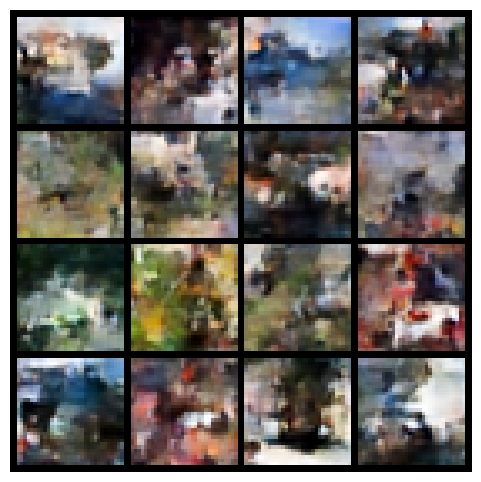

In [10]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_and_show(n=16, steps=None):
    steps = steps if steps is not None else cfg.sample_steps
    x = heun_sampler(
        ema_model, batch_size=n, steps=steps,
        sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho,
        device=device
    )
    # back to [0,1] for display
    x_vis = (x + 1.0) * 0.5
    grid = make_grid(x_vis, nrow=int(math.sqrt(n)), padding=2)
    npimg = grid.permute(1,2,0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(np.clip(npimg, 0, 1))
    plt.axis("off")
    plt.show()

sample_and_show(n=16, steps=cfg.sample_steps)


In [11]:
@torch.no_grad()
def heun_sampler_with_energy(model_ema, batch_size=16, steps=40,
                             sigma_min=0.002, sigma_max=80.0, rho=7.0, device='cpu'):
    """Same sampler, but also returns the learned scalar v (energy/logsigma proxy) along the path."""
    model_ema.eval()
    sigmas = karras_sigma_schedule(steps, sigma_min, sigma_max, rho=rho, device=device)
    x = torch.randn(batch_size, cfg.channels, cfg.image_size, cfg.image_size, device=device) * sigmas[0]
    energies = []

    def v_head(x, sigma):
        log_sigma = torch.log(sigma.clamp(min=1e-12))
        _, v = model_ema(x, log_sigma)
        return v.mean(dim=(1,2,3))

    for i in range(steps):
        sigma_i = sigmas[i]
        sigma_next = sigmas[i+1]
        # measure "energy" at step i
        if cfg.with_v_head:
            energies.append(v_head(x, sigma_i).mean().item())

        x0_hat = denoise_fn(model_ema, x, sigma_i)
        d_i = (x - x0_hat) / sigma_i.clamp(min=1e-12)
        x_euler = x + (sigma_next - sigma_i) * d_i
        if sigma_next > 0:
            x0_hat_next = denoise_fn(model_ema, x_euler, sigma_next)
            d_next = (x_euler - x0_hat_next) / sigma_next.clamp(min=1e-12)
            x = x + (sigma_next - sigma_i) * 0.5 * (d_i + d_next)
        else:
            x = x_euler

    x = x.clamp(-1,1)
    if cfg.with_v_head:
        energies.append(v_head(x, torch.tensor(1e-6, device=device)).mean().item())
    return x, energies

# Example monitoring:
samples, energies = heun_sampler_with_energy(
    ema_model, batch_size=8, steps=cfg.sample_steps,
    sigma_min=cfg.sigma_min, sigma_max=cfg.sigma_max, rho=cfg.rho, device=device
)
print("Energy trace (avg per step):", energies[:10], "...", energies[-3:])


Energy trace (avg per step): [1.9295845031738281, 1.9041805267333984, 1.7815381288528442, 1.8245810270309448, 1.7507615089416504, 1.6321885585784912, 1.6996991634368896, 1.5313708782196045, 1.4012151956558228, 1.3085294961929321] ... [-3.46319317817688, -2.879626750946045, -2.2516231536865234]
